# Python Notebook to explore the PVLens Data
- @author: Jeffery Painter
- @modified: 2025-May-01

In [11]:
import pandas as pd
import os

In [17]:
# Base data directory
data = "../data/"
review_dir = os.path.join(data, "review_results")
mdr_dict_infile = os.path.join(data, "dictionary", "meddra.csv")
guid_dict_infile = os.path.join(data, "dictionary", "guid_to_xml.csv")

# Load data
mdr_dict = pd.read_csv(mdr_dict_infile)
guid_to_xml = pd.read_csv(guid_dict_infile)

# Define label directories
label_dirs = {
    "AE": os.path.join(data, "extracted_labels", "aes"),
    "BLACKBOX": os.path.join(data, "extracted_labels", "blackbox"),
    "INDICATION": os.path.join(data, "extracted_labels", "indications")
}

In [18]:
mdr_dict.head(n=4)

,ID,AUI,CUI,CODE,TTY,TERM
0,130,A0072077,C1258215,10021328,PT,ileus
1,159,A25723087,C0920028,10062492,LLT,leukemia recurrent
2,165,A25723080,C0860450,10062446,LLT,generalized skin reaction
3,190,A25723071,C0001807,10062375,LLT,aggressive behavior


# Load the Raw Text narrative for the extracted AEs

In [19]:
# Function to read guid.txt from appropriate label directory
def load_label_text(guid, label_type):
    path = os.path.join(label_dirs[label_type], f"{guid}.txt")
    try:
        with open(path, "r", encoding="utf-8") as f:
            return f.read().strip()
    except FileNotFoundError:
        return pd.NA

# Add columns to dataframe
for label in label_dirs:
    guid_to_xml[label] = guid_to_xml["GUID"].apply(lambda g: load_label_text(g, label))

In [20]:
# Display updated dataframe
guid_to_xml.head(n=3)

,SPL_ID,GUID,XML_FILE,AE,BLACKBOX,INDICATION
0,100,b702dcc9-dd0e-4386-b1e2-f20562fd2ad9,b702dcc9-dd0e-4386-b1e2-f20562fd2ad9.xml,The following clinically significant adverse r...,"WARNING: SEVERE MYELOSUPPRESSION, CARCINOGENIC...",Thiotepa for injection is an alkylating drug i...
1,104,75672079-589f-451a-bdbf-eaebcfcc80a9,282ae0c1-e1f3-4045-af1d-bc2f6bd7b4e2.xml,The most common adverse reactions (≥2%) in adu...,<NA>,SIVEXTRO is an oxazolidinone antibacterial ind...
2,105,7bcfbac2-e8ac-4569-8edc-bcde3b1fd172,3d940554-158d-4303-ae20-78fa76106c73.xml,The following adverse reactions are also discu...,<NA>,PRALUENT ® is indicated:<br>PRALUENT is a prop...


# Load the mapped terms and adjudicated results

In [21]:
# Helper function to load and process each review file
def load_review_file(filename, section_name):
    path = os.path.join(review_dir, filename)
    df = pd.read_csv(path, usecols=["SPL_ID", "MDR_CODE", "INCLUDE"])
    df["SECTION"] = section_name
    return df

# Load and label each section's review
ae_df = load_review_file("ae_reviews.csv", "AE")
bb_df = load_review_file("blackbox_reviews.csv", "BlackBox")
ind_df = load_review_file("ind_reviews.csv", "Indication")

# Combine all into one DataFrame
reviews = pd.concat([ae_df, bb_df, ind_df], ignore_index=True)


In [25]:
# Merge with MedDRA dictionary to get TERM and CODE
mdr_subset = mdr_dict[["ID", "CODE", "TERM"]].rename(columns={"ID": "MDR_CODE", "CODE": "CODE", "TERM": "TERM"})
merged = reviews.merge(mdr_subset, on="MDR_CODE", how="left")

# Merge with GUID info
spl_mapped_terms = merged.merge(guid_to_xml[["SPL_ID", "GUID"]], on="SPL_ID", how="left")

# Reorder and rename columns
spl_mapped_terms = spl_mapped_terms[["SPL_ID", "GUID", "SECTION", "MDR_CODE", "CODE", "TERM", "INCLUDE"]]
spl_mapped_terms = spl_mapped_terms.rename(columns={"MDR_CODE": "MedDRA_ID"})

spl_mapped_terms["INCLUDE"] = spl_mapped_terms["INCLUDE"].astype(bool)

In [26]:
# Display the result
spl_mapped_terms.head(n=5)

,SPL_ID,GUID,SECTION,MedDRA_ID,CODE,TERM,INCLUDE
0,100,b702dcc9-dd0e-4386-b1e2-f20562fd2ad9,AE,159,10062492,leukemia recurrent,True
1,100,b702dcc9-dd0e-4386-b1e2-f20562fd2ad9,AE,422,10063045,effusion,False
2,100,b702dcc9-dd0e-4386-b1e2-f20562fd2ad9,AE,573,10012378,depression,True
3,100,b702dcc9-dd0e-4386-b1e2-f20562fd2ad9,AE,936,10042033,stevens-johnson syndrome,True
4,100,b702dcc9-dd0e-4386-b1e2-f20562fd2ad9,AE,1927,10047862,weakness,True


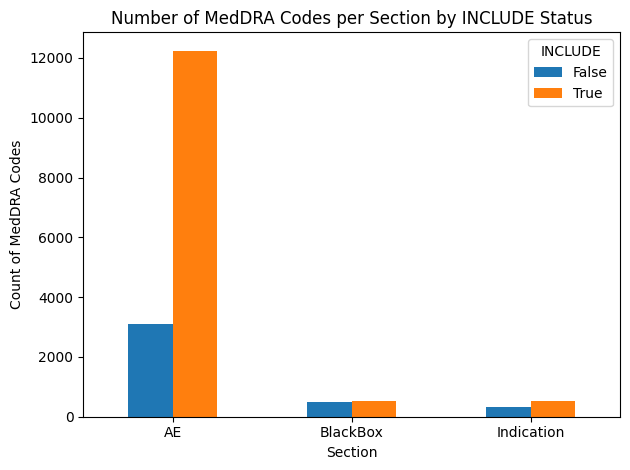

In [27]:
import matplotlib.pyplot as plt

# Ensure INCLUDE is boolean
spl_mapped_terms["INCLUDE"] = spl_mapped_terms["INCLUDE"].astype(bool)

# Group by SECTION and INCLUDE, count MedDRA_IDs
grouped = spl_mapped_terms.groupby(["SECTION", "INCLUDE"]).size().unstack(fill_value=0)

# Plot the grouped counts
ax = grouped.plot(kind="bar", stacked=False)
ax.set_title("Number of MedDRA Codes per Section by INCLUDE Status")
ax.set_ylabel("Count of MedDRA Codes")
ax.set_xlabel("Section")
ax.legend(title="INCLUDE")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
